In [1]:
import os
import glob
import os
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from tqdm import tqdm
import time
from scipy.spatial.distance import cdist
import scipy
from scanpy.tools._utils import get_init_pos_from_paga 

import rmm
import cupy
import cudf
import cupy as cp
# import cvxpy as cpv
from cuml.metrics import pairwise_distances
from cuml.metrics import nan_euclidean_distances
from rmm.allocators.cupy import rmm_cupy_allocator
import anndata as an
import scanpy as sc
import rapids_singlecell as rsc
import scvi

# Enable `managed_memory`
rmm.reinitialize(
    managed_memory=True,
    pool_allocator=False,
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [2]:
%%time
fpath = "../resources/gene_names.tsv.gz"
gdf = pd.read_csv(fpath, sep='\t', low_memory=False)
print(f"{gdf.shape=}")

protein_coding = gdf[gdf['Gene type'] == 'protein_coding']['Gene name'].unique()
print(f"N protein coding: {protein_coding.shape=}")

gdf.shape=(73466, 8)
N protein coding: protein_coding.shape=(18149,)
CPU times: user 132 ms, sys: 14 ms, total: 146 ms
Wall time: 148 ms


In [3]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/single_cell_atlas.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 1.57 s, sys: 9.62 s, total: 11.2 s
Wall time: 31.9 s


/nfs/turbo/umms-indikar/Jillian/conda-envs/rapids/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 521040 × 17603
    obs: 'annotation', 'cell_type', 'tissue', 'development_stage', 'basename', 'dataset_id', 'data_key', 'data_source', 'celltype', 'source'

In [4]:
print(adata.obs['data_key'].value_counts().to_string())
print(adata.obs['source'].value_counts().to_string())

data_key
Ng 2024       250000
Reference     250000
This Study     20754
Gomes 2018       286
source
hsc            8336
fib            6960
bone_marrow    5458


# data source variable

In [5]:
print(f"{adata.obs.shape=}")

adata.obs["batch_key"] = adata.obs["dataset_id"].astype(str)
adata.obs["batch_key"] = np.where(adata.obs["batch_key"] == 'nan', adata.obs["data_key"].astype(str), adata.obs["batch_key"])
adata.obs["batch_key"] = np.where(adata.obs["data_key"] == 'This Study', adata.obs["source"].astype(str), adata.obs["batch_key"])

print(adata.obs[['batch_key', 'data_key', 'data_source']].head().to_string())

print()

print(adata.obs["batch_key"].value_counts(dropna=False).head(25))

adata.obs.shape=(521040, 10)
                                   batch_key   data_key data_source
423698  18e2a8c5-33f7-455e-a58a-b2ba6921db27  Reference           0
915257  f7c1c579-2dc0-47e2-ba19-8165c5a0e353  Reference           0
295115  9d8e5dca-03a3-457d-b7fb-844c75735c83  Reference           0
264081  2adb1f8a-a6b1-4909-8ee8-484814e2d4bf  Reference           0
647819  842c6f5d-4a94-4eef-8510-8c792d1124bc  Reference           0

batch_key
Ng 2024                                 250000
842c6f5d-4a94-4eef-8510-8c792d1124bc     23602
0ba636a1-4754-4786-a8be-7ab3cf760fd6     20205
fd072bc3-2dfb-46f8-b4e3-467cb3223182     18726
d4e69e01-3ba2-4d6b-a15d-e7048f78f22e     18410
2adb1f8a-a6b1-4909-8ee8-484814e2d4bf     15358
55003f67-c494-46f1-83fb-902745646379     11053
9968be68-ab65-4a38-9e1a-c9b6abece194     10411
535e9336-2d8d-43c3-944d-bcbebe20df8a      9519
18e2a8c5-33f7-455e-a58a-b2ba6921db27      9313
471647b3-04fe-4c76-8372-3264feb950e8      8410
hsc                                

In [6]:
threshold = 100 # fewer than 10 cells from a given source are dropped

# Count how many times each batch appears
batch_counts = adata.obs["batch_key"].value_counts()

# Identify non-unique batch keys
non_unique_batches = batch_counts[batch_counts > threshold].index

# Subset the AnnData to only those with non-unique batch keys
adata = adata[adata.obs["batch_key"].isin(non_unique_batches)].copy()

print(f"{adata.shape=}")
adata

adata.shape=(518379, 17603)


/nfs/turbo/umms-indikar/Jillian/conda-envs/rapids/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 518379 × 17603
    obs: 'annotation', 'cell_type', 'tissue', 'development_stage', 'basename', 'dataset_id', 'data_key', 'data_source', 'celltype', 'source', 'batch_key'

# preprocessing

In [7]:
%%time
regev_genes = [x.strip() for x in open('../resources/regev_lab_cell_cycle_genes.txt')]
s_genes = regev_genes[:43]
g2m_genes = regev_genes[43:]

sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=s_genes,
    g2m_genes=g2m_genes,
)

adata.obs.head()

CPU times: user 1min 20s, sys: 42.1 s, total: 2min 2s
Wall time: 2min 2s


,annotation,cell_type,tissue,development_stage,basename,dataset_id,data_key,data_source,celltype,source,batch_key,S_score,G2M_score,phase
423698,mesenchymal cell,mesenchymal cell,gonad,9th week post-fertilization human stage,mesenchymal_cells,18e2a8c5-33f7-455e-a58a-b2ba6921db27,Reference,0,NaN,NaN,18e2a8c5-33f7-455e-a58a-b2ba6921db27,0.552407,-0.265084,S
915257,endothelial cell of vascular tree,endothelial cell of vascular tree,adrenal gland,12th week post-fertilization human stage,endothelial_cells,f7c1c579-2dc0-47e2-ba19-8165c5a0e353,Reference,0,NaN,NaN,f7c1c579-2dc0-47e2-ba19-8165c5a0e353,0.029012,0.017428,S
295115,endothelial cell,endothelial cell,visceral abdominal adipose tissue,51-year-old human stage,endothelial_cells,9d8e5dca-03a3-457d-b7fb-844c75735c83,Reference,0,NaN,NaN,9d8e5dca-03a3-457d-b7fb-844c75735c83,-0.133240,-0.091949,G1
264081,mesenchymal stem cell,mesenchymal stem cell,lung,11th week post-fertilization human stage,mesenchymal_cells,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,Reference,0,NaN,NaN,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,0.000316,-0.005524,S
647819,fibroblast,fibroblast,breast,mature stage,fibroblasts,842c6f5d-4a94-4eef-8510-8c792d1124bc,Reference,0,NaN,NaN,842c6f5d-4a94-4eef-8510-8c792d1124bc,-0.243424,-0.209202,G1


In [8]:
%%time
rsc.get.anndata_to_CPU(adata)
X = adata.X

if sp.issparse(X):
    # replace NaNs in the nonzero entries
    X.data = np.nan_to_num(X.data, nan=0)
    adata.X = X
else:
    # dense array
    adata.X = np.nan_to_num(X, nan=0)

adata.X = adata.X.astype(float)
print(f"{adata.X.shape=}")
print(f"{type(adata.X)=}")
print(f"{adata.X.dtype=}")

adata

adata.X.shape=(518379, 17603)
type(adata.X)=<class 'scipy.sparse._csr.csr_matrix'>
adata.X.dtype=dtype('float64')
CPU times: user 19.2 s, sys: 15.1 s, total: 34.2 s
Wall time: 34.4 s


AnnData object with n_obs × n_vars = 518379 × 17603
    obs: 'annotation', 'cell_type', 'tissue', 'development_stage', 'basename', 'dataset_id', 'data_key', 'data_source', 'celltype', 'source', 'batch_key', 'S_score', 'G2M_score', 'phase'

In [9]:
adata.var['filter_pass'] = True # set the gene filter

# pt genes only
adata.var['filter_pass'] = np.where(~adata.var.index.isin(protein_coding), False, adata.var['filter_pass'])

# disallow mitochondrial and ribosomal genes
adata.var['filter_pass'] = np.where(adata.var.index.str.startswith('MT'), False, adata.var['filter_pass'])
adata.var['filter_pass'] = np.where(adata.var.index.str.startswith('RP'), False, adata.var['filter_pass'])

print(adata.var['filter_pass'].value_counts().to_string())

filter_pass
True     17375
False      228


In [10]:
%%time
print("Annotating mitochondrial, ribosomal, and hemoglobin genes...")
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

print("Moving AnnData to CPU for QC metric calculation...")
rsc.get.anndata_to_CPU(adata)

print("Calculating QC metrics (log1p transformed)...")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], 
    inplace=True, log1p=True
)

adata.var.head()

Annotating mitochondrial, ribosomal, and hemoglobin genes...
Moving AnnData to CPU for QC metric calculation...
Calculating QC metrics (log1p transformed)...
CPU times: user 41.2 s, sys: 5.18 s, total: 46.4 s
Wall time: 47.2 s


,filter_pass,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
A1CF,True,False,False,False,765,0.004965,0.004953,99.852425,2.573751e+03,7.853508
A2M,True,False,False,False,106714,4.090497,1.627375,79.413904,2.120428e+06,14.567129
A2ML1,True,False,False,False,1209,0.002861,0.002857,99.766773,1.482918e+03,7.302441
A3GALT2,True,False,False,False,314,0.000644,0.000644,99.939427,3.340000e+02,5.814131
A4GALT,True,False,False,False,36052,0.133180,0.125027,93.045243,6.903751e+04,11.142420


# filtering + normalization

In [11]:
%%time

print("Storing raw counts in .layers['raw_counts']...")
adata.layers['raw_counts'] = adata.X.copy()

print("Transferring AnnData back to GPU...")
rsc.get.anndata_to_GPU(adata)

print("Filtering cells with fewer than 500 counts...")
rsc.pp.filter_cells(adata, min_counts=500)

print("Filtering genes with fewer than 10 total counts...")
rsc.pp.filter_genes(adata, min_counts=10)

print("Filtering genes with zero counts across all cells...")
adata = adata[:, (adata.var['total_counts'] > 0)].copy()

min_n_genes = 1000
print(f"Subsetting cells with more than {min_n_genes} genes detected...")
adata = adata[adata.obs['n_genes_by_counts'] > min_n_genes, :].copy()

print("Normalizing total counts to 1e4 per cell...")
rsc.pp.normalize_total(adata, target_sum=1e4)

print("Applying log1p transformation...")
rsc.pp.log1p(adata)

print("Computing highly variable genes...")
rsc.pp.highly_variable_genes(adata)

print("Storing log-normalized data in .layers['log_norm']...")
adata.layers['log_norm'] = adata.X.copy()

print("Preprocessing complete.")
adata

Storing raw counts in .layers['raw_counts']...
Transferring AnnData back to GPU...
Filtering cells with fewer than 500 counts...
filtered out 17742 cells that have less than 500 counts


/nfs/turbo/umms-indikar/Jillian/conda-envs/rapids/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Filtering genes with fewer than 10 total counts...
filtered out 225 genes that are detected in less than 10 counts


/nfs/turbo/umms-indikar/Jillian/conda-envs/rapids/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Filtering genes with zero counts across all cells...
Subsetting cells with more than 1000 genes detected...
Normalizing total counts to 1e4 per cell...
Applying log1p transformation...
Computing highly variable genes...
Storing log-normalized data in .layers['log_norm']...
Preprocessing complete.
CPU times: user 48 s, sys: 58.3 s, total: 1min 46s
Wall time: 1min 47s


AnnData object with n_obs × n_vars = 420266 × 17378
    obs: 'annotation', 'cell_type', 'tissue', 'development_stage', 'basename', 'dataset_id', 'data_key', 'data_source', 'celltype', 'source', 'batch_key', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes'
    var: 'filter_pass', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_counts', 'log_norm'

In [24]:
adata.obs['data_key'].value_counts()

data_key
Ng 2024       232058
Reference     167305
This Study     20620
Gomes 2018       283
Name: count, dtype: int64

In [27]:
adata.obs[adata.obs['data_key'] == 'This Study']['source'].value_counts()

source
hsc            8228
fib            6960
bone_marrow    5432
Name: count, dtype: int64

In [29]:
# create new grouping that separates This Study 
adata.obs["data_key_new"] = (
    adata.obs["data_key"].astype(str)
    .where(adata.obs["data_key"] != "This Study", adata.obs["source"].astype(str))
)

adata.obs['data_key_new'] = adata.obs['data_key_new'].astype('category')

adata.obs["data_key_new"].value_counts()

data_key_new
Ng 2024        232058
Reference      167305
hsc              8228
fib              6960
bone_marrow      5432
Gomes 2018        283
Name: count, dtype: int64

In [34]:
adata

AnnData object with n_obs × n_vars = 420266 × 17378
    obs: 'annotation', 'cell_type', 'tissue', 'development_stage', 'basename', 'dataset_id', 'data_key', 'data_source', 'celltype', 'source', 'batch_key', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'data_key_new'
    var: 'filter_pass', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_counts', 'log_norm'

# scvi

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
%%time
# batch_key = "batch_key"
batch_key = 'data_key_new'

rsc.get.anndata_to_CPU(adata)
bdata = adata.copy()
bdata = bdata[:, bdata.var['filter_pass']].copy()
bdata.X = bdata.layers['raw_counts'].copy()

rsc.get.anndata_to_GPU(bdata)
rsc.pp.highly_variable_genes(
    bdata,
    flavor="seurat_v3",
    n_top_genes=3000,
    # batch_key=batch_key
)

bdata = bdata[:, bdata.var['highly_variable']].copy()
rsc.get.anndata_to_CPU(bdata)

# scvi
scvi.model.SCVI.setup_anndata(
    bdata, 
    batch_key=batch_key,
    continuous_covariate_keys=['S_score', 'G2M_score'],
)

model = scvi.model.SCVI(
    bdata,
    n_hidden=128,
    n_latent=24,
    n_layers=2, 
    dispersion='gene-cell',
    gene_likelihood='zinb',
)

model.train(
    max_epochs=500,
    accelerator='gpu',
    early_stopping_patience=30,
    early_stopping=True,
    batch_size=500,
    plan_kwargs={"lr": 1e-3},
)

history = model.history

metrics = [
    ("train_loss_epoch", "validation_loss"),
    ("elbo_train", "elbo_validation"),
    ("reconstruction_loss_train", "reconstruction_loss_validation"),
    ("kl_local_train", "kl_local_validation"),
]

plt.rcParams['figure.dpi'] = 200
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.flatten()

for i, (train_key, val_key) in enumerate(metrics):
    ax = axes[i]
    train_df = history[train_key]
    val_df = history[val_key]

    ax.plot(train_df.index, train_df[train_key], label='Train')
    ax.plot(val_df.index, val_df[val_key], label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(train_key.replace('_train', '').replace('_', ' ').title())
    ax.set_title(train_key.replace('_train', '').replace('_', ' ').title())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

INFO: GPU available: True (cuda), used: True
2025-12-12 14:36:20 | [INFO] GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-12-12 14:36:20 | [INFO] TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-12-12 14:36:20 | [INFO] HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-12-12 14:36:20 | [INFO] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-12-12 14:36:20 | [INFO] SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

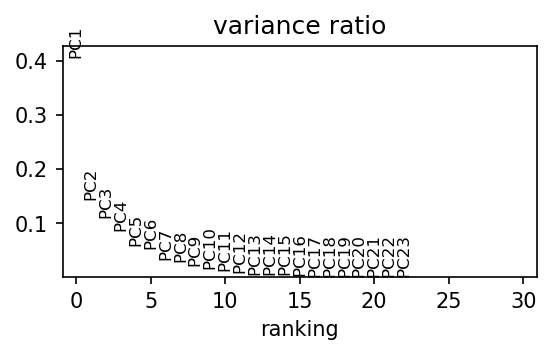

CPU times: user 5.29 s, sys: 340 ms, total: 5.63 s
Wall time: 5.68 s


In [31]:
%%time 

embed = model.get_latent_representation()
embed = sc.AnnData(embed, obs=adata.obs)

rsc.get.anndata_to_GPU(embed)

rsc.pp.pca(embed)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 4, 2
sc.pl.pca_variance_ratio(embed)

... storing 'batch_key' as categorical
... storing 'phase' as categorical
... storing 'cluster' as categorical



cluster
A21    76231
A5     35663
A16    33905
A12    32268
A15    27704
A23    24236
A2     21283
A1     20412
A22    17402
A3     15824
A6     14358
A4     11925
A17    11765
A18    11492
A11     9272
A7      8915
A8      8243
A14     7166
A13     6496
A9      6187
A20     5481
A25     4232
A24     3021
A10     3008
A27     1150
A19     1094
A28      981
A26      552



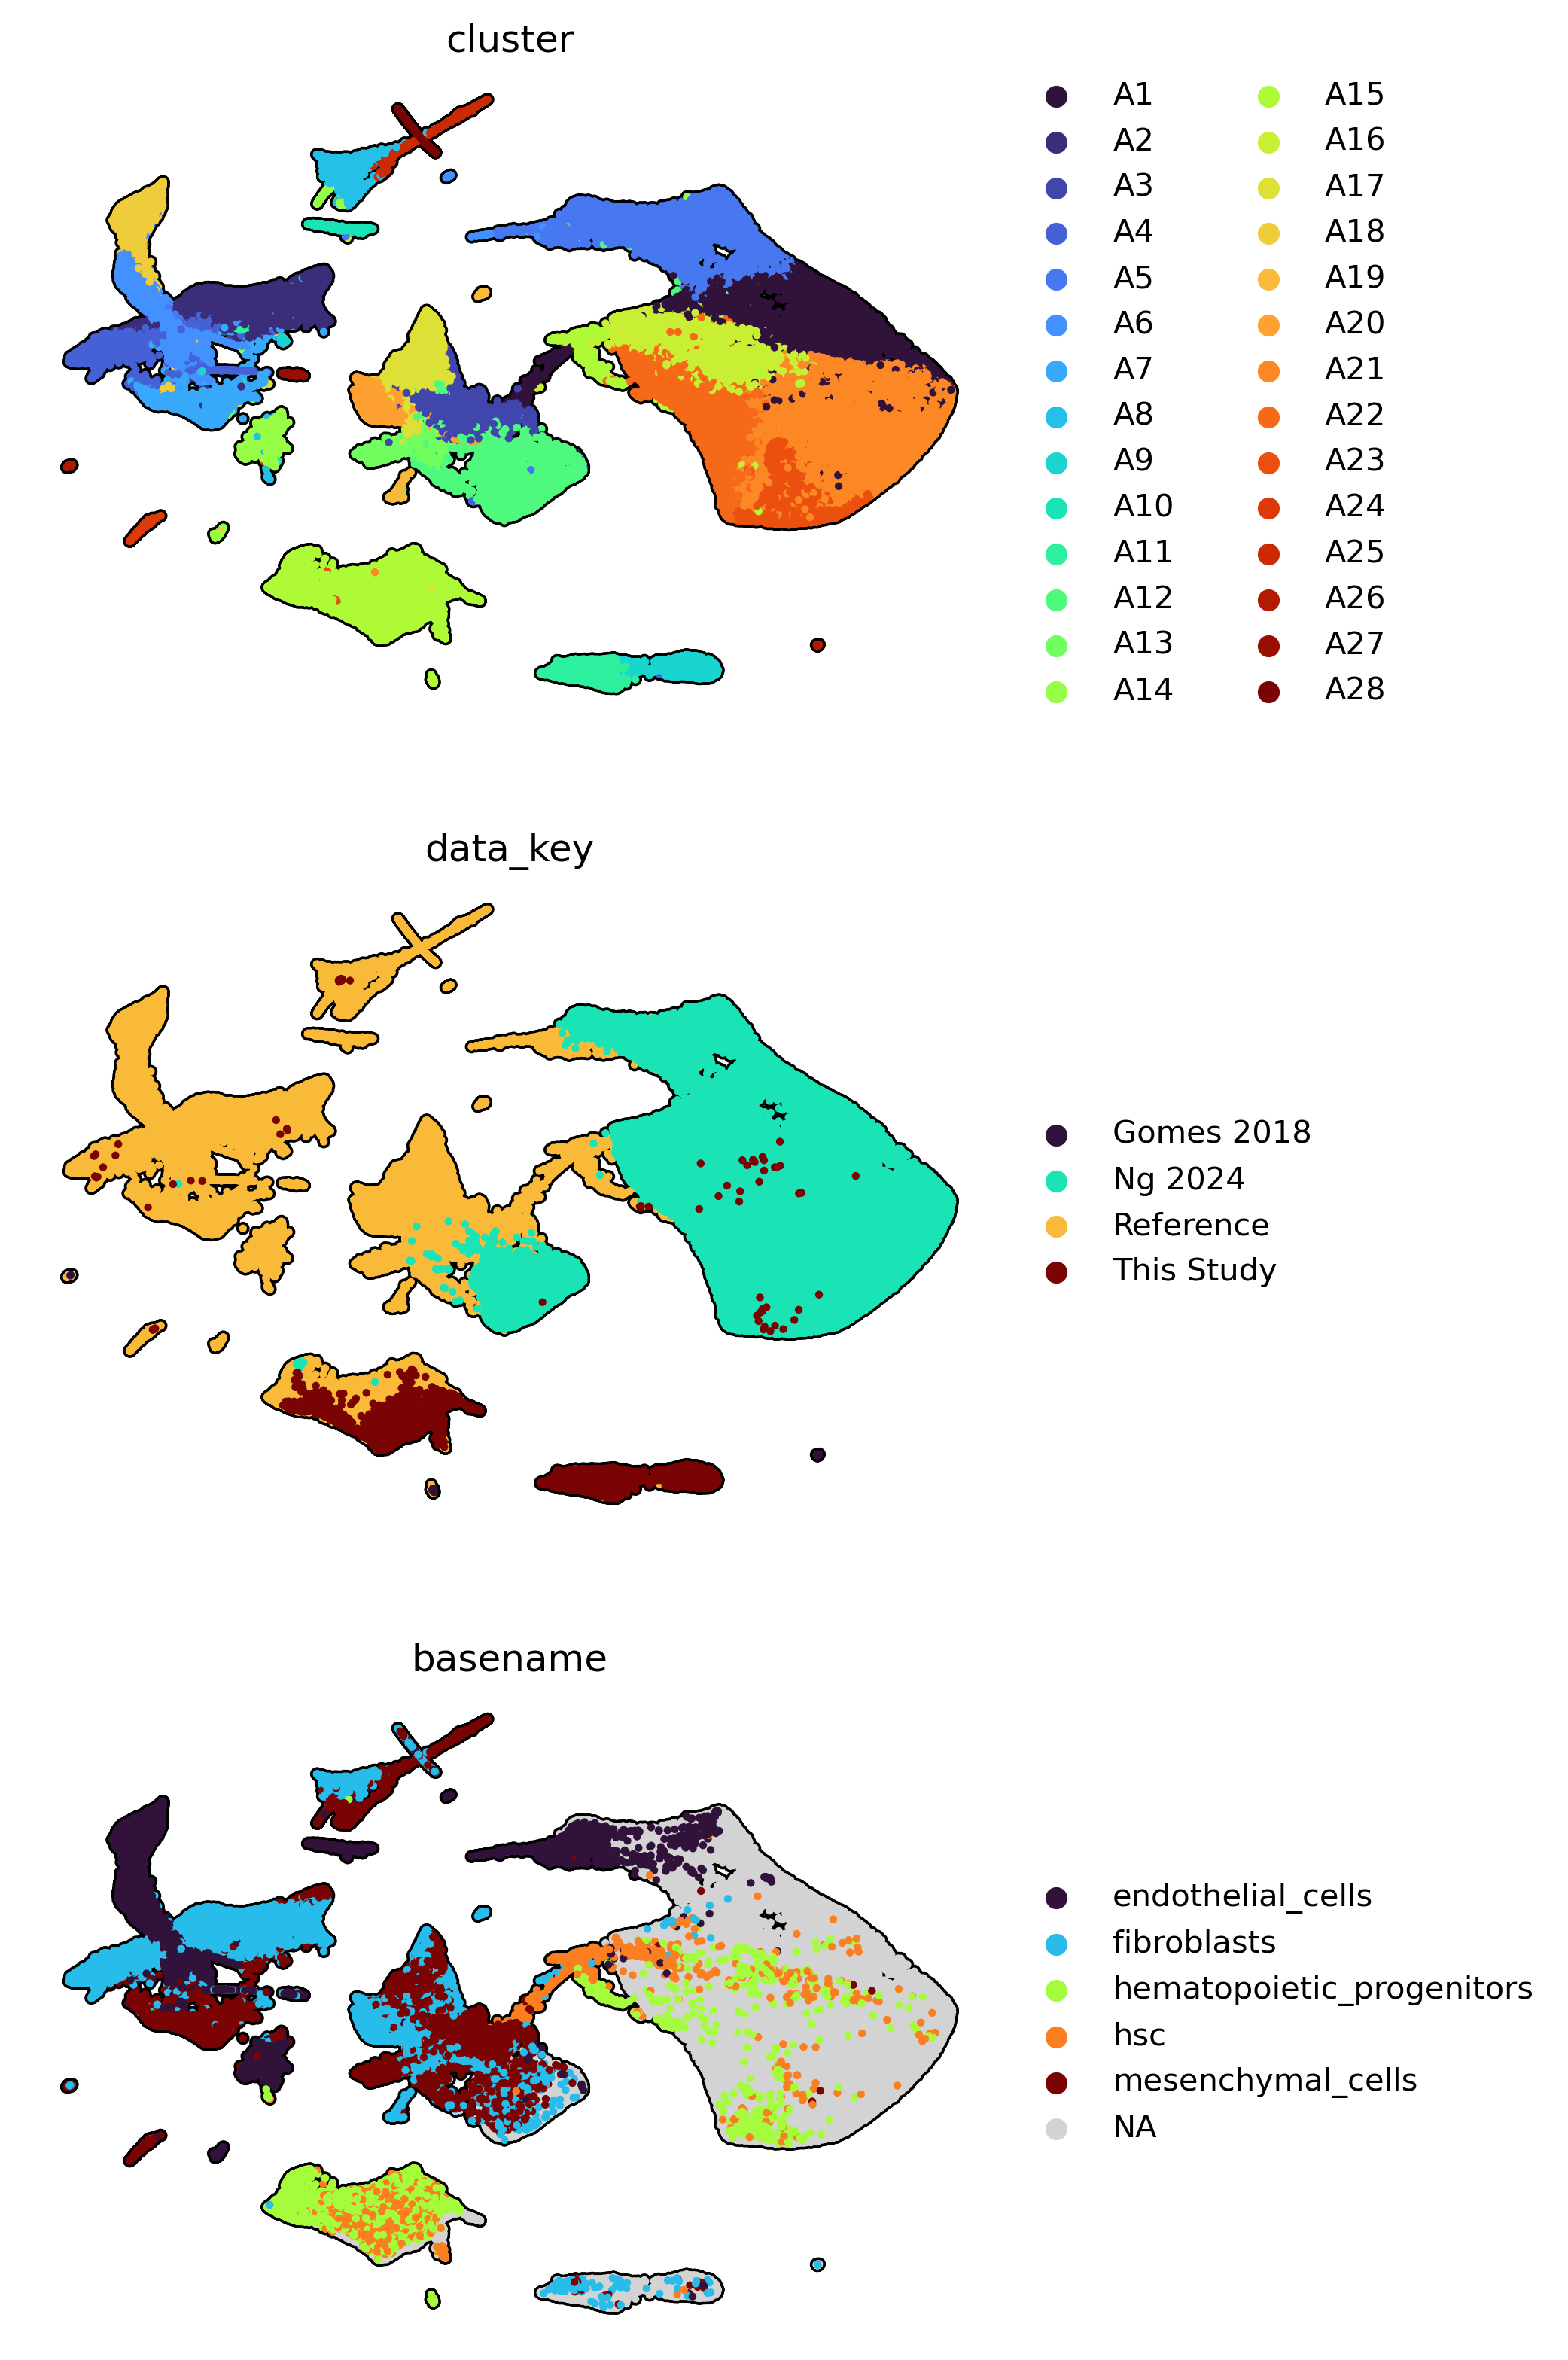

CPU times: user 35.4 s, sys: 4.49 s, total: 39.9 s
Wall time: 40.1 s


In [32]:
%%time
n_neighbors = 15
n_pcs = 25

rsc.pp.neighbors(
    embed, 
    n_pcs=n_pcs, 
    n_neighbors=n_neighbors,
)

rsc.tl.umap(embed, min_dist=0.2, )
rsc.tl.leiden(embed, resolution=0.45, random_state=1729)

embed.obs['cluster'] = embed.obs['leiden'].apply(lambda x: f"A{int(x) + 1}")
embed.obs['cluster'] = embed.obs['cluster'].astype('str')

print()
print(embed.obs['cluster'].value_counts().to_string())
print()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.umap(
    embed,
    color=['cluster', 'data_key', 'basename'],
    palette='turbo',
    size=25,
    ncols=1,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.5,
)

In [17]:
embed

AnnData object with n_obs × n_vars = 420266 × 24
    obs: 'annotation', 'cell_type', 'tissue', 'development_stage', 'basename', 'dataset_id', 'data_key', 'data_source', 'celltype', 'source', 'batch_key', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'leiden', 'cluster'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'cluster_colors', 'data_key_colors', 'basename_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [19]:
embed.obs['cluster'].value_counts()

cluster
A1     43606
A7     43465
A15    42455
A22    39086
A24    35466
A8     25604
A4     22303
A3     21993
A13    21526
A6     19545
A5     18001
A10    12275
A9     11277
A17    10643
A2     10464
A14    10223
A12     7728
A18     6083
A20     4362
A16     3590
A21     3371
A11     2849
A19     1821
A25     1332
A23     1198
Name: count, dtype: int64

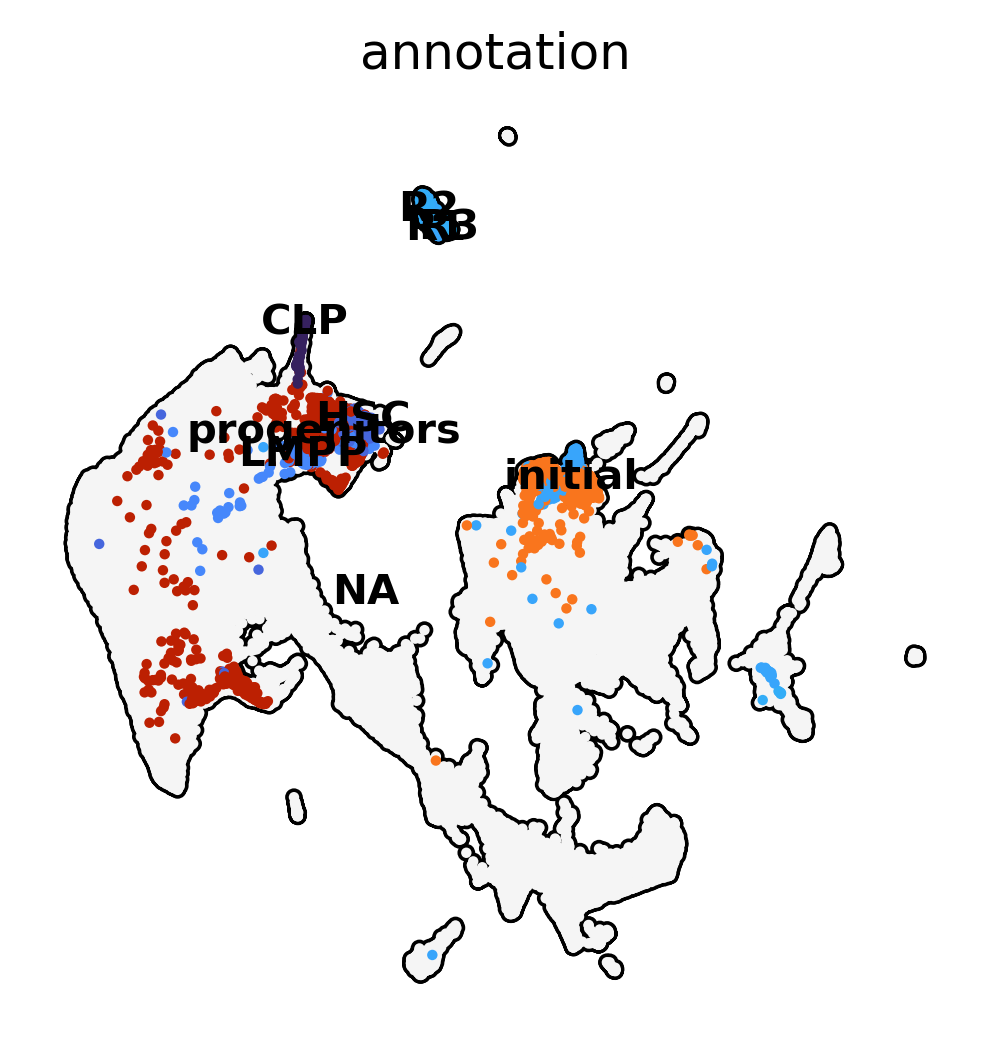

In [20]:
mask = embed.obs['data_key'] == 'This Study'

sc.pl.umap(
    embed,
    color=['annotation'],
    mask_obs=mask,
    palette='turbo',
    na_color='whitesmoke',
    size=25,
    ncols=1,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
    wspace=0.5,
    legend_loc='on data',
)